### Import Library

In [67]:
import pandas as pd   # Import library pandas untuk manipulasi data
import numpy as np    # Import library numpy untuk operasi numerik
import matplotlib.pyplot as plt   # Import library matplotlib untuk membuat plot/grafik
from sklearn.metrics import mean_squared_error, mean_absolute_error   # Import fungsi evaluasi error dari scikit-learn
from tensorflow.keras.models import Sequential    # Import kelas untuk membuat model Sequential dari Keras
from tensorflow.keras.layers import LSTM, Dense   # Import layer LSTM dan Dense dari Keras
from sklearn.preprocessing import MinMaxScaler    # Import scaler MinMax dari scikit-learn untuk normalisasi data
from math import sqrt   # Import fungsi sqrt dari math untuk menghitung akar kuadrat

### Load Data

In [68]:
# Load dataset dari file CSV, parsing kolom 'timestamp' sebagai datetime
df = pd.read_csv('london bike sharing.csv', parse_dates=['timestamp'])

In [69]:
# Menampilkan 5 baris dataset
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [70]:
# Menampilkan summary dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


### Data Preprocessing & Exploratory Data Analysis

In [71]:
# Pilih hanya kolom 'timestamp' dan 'cnt', lalu urutkan berdasarkan 'timestamp'
df = df[['timestamp', 'cnt']].sort_values('timestamp')

# Set kolom 'timestamp' sebagai index dan resample data menjadi data harian (mengakumulasi per hari)
daily_df = df.set_index('timestamp').resample('D').sum()

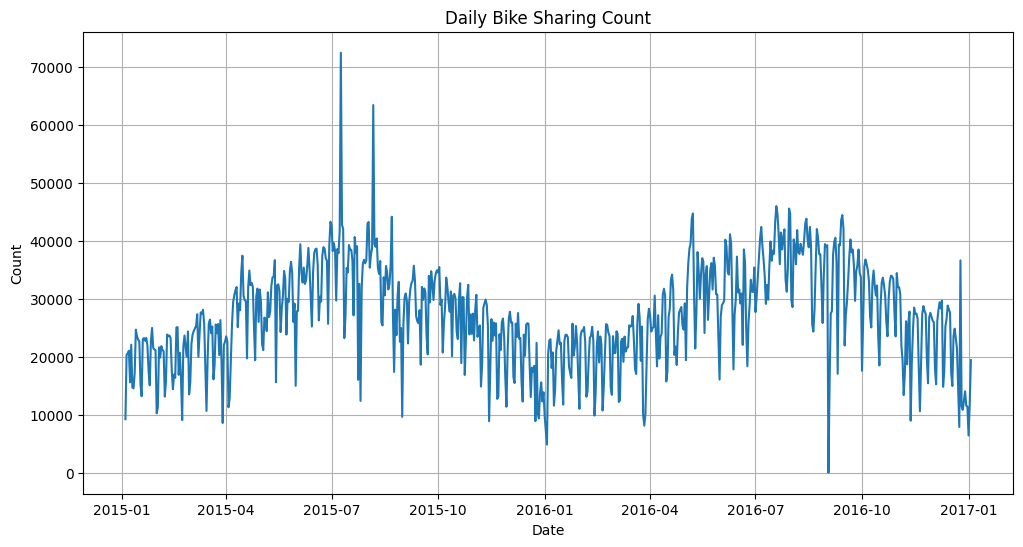

In [72]:
# Plot data harian
plt.figure(figsize=(12, 6))   # Membuat figure berukuran 12x6 untuk plot
plt.plot(daily_df.index, daily_df['cnt'])   # Plot jumlah peminjaman sepeda per hari
plt.title('Daily Bike Sharing Count')   # Menambahkan judul pada grafik
plt.xlabel('Date')    # Menambahkan label sumbu X
plt.ylabel('Count')   # Menambahkan label sumbu Y
plt.grid()    # Menampilkan grid pada grafik
plt.show()    # Menampilkan grafik ke layar

Interpretasi :
- Terlihat ada pola musiman tahunan (lebih tinggi di musim panas).

- Ada tren jangka panjang yang naik-turun mengikuti musim.

- Ada beberapa lonjakan dan penurunan ekstrem (outlier).

Jadi, grafik ini tidak terlihat seperti random walk klasik, melainkan lebih seperti seasonal time series dengan noise.

In [73]:
# Menampilkan 5 baris data harian
daily_df.head()

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601


In [74]:
# Menampilkan summary data harian
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2015-01-04 to 2017-01-03
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cnt     731 non-null    int64
dtypes: int64(1)
memory usage: 11.4 KB


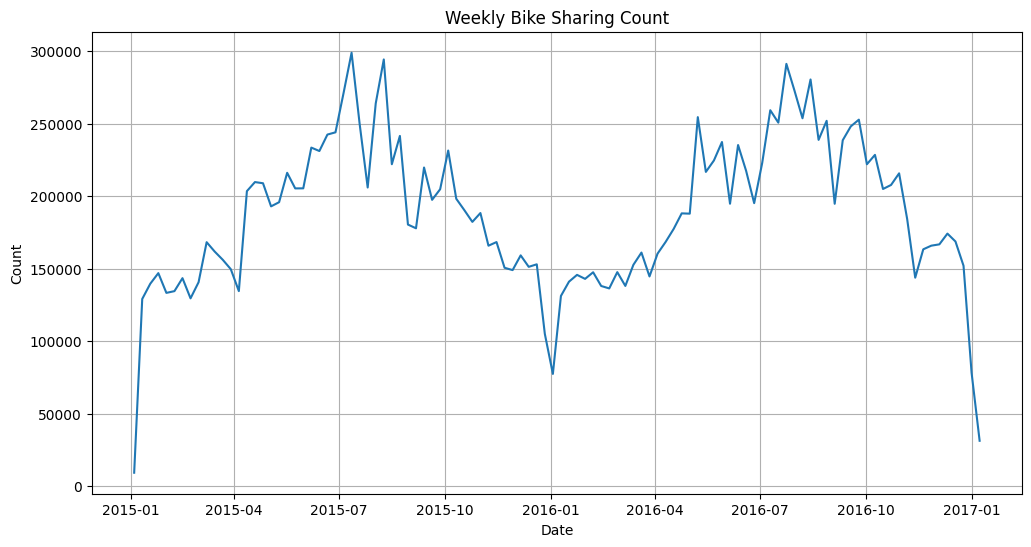

In [75]:
# Set kolom 'timestamp' sebagai index dan resample data menjadi data mingguan (mengakumulasi per minggu)
weekly_df = df.set_index('timestamp').resample('W').sum()

# Plot data mingguan
plt.figure(figsize=(12, 6))   # Membuat figure berukuran 12x6 untuk plot
plt.plot(weekly_df.index, weekly_df['cnt'])   # Plot jumlah peminjaman sepeda per minggu
plt.title('Weekly Bike Sharing Count')   # Menambahkan judul pada grafik
plt.xlabel('Date')  # Menambahkan label sumbu X
plt.ylabel('Count') # Menambahkan label sumbu Y
plt.grid()    # Menampilkan grid pada grafik
plt.show()    # Menampilkan grafik ke layar

Interpretasi : <br>
Grafik ini menunjukkan jumlah penggunaan sepeda harian dari awal 2015 hingga akhir 2016.
Secara umum, tren penggunaan sepeda meningkat saat musim panas (sekitar pertengahan tahun) dan menurun saat musim dingin (akhir tahun). Ada juga beberapa fluktuasi tajam yang mungkin disebabkan oleh faktor cuaca ekstrem atau event tertentu.

In [76]:
# Menampilkan 5 baris data mingguan
weekly_df.head()

,cnt
timestamp,
2015-01-04,9234
2015-01-11,129038
2015-01-18,139559
2015-01-25,146866
2015-02-01,133247


In [77]:
# Menampilkan summary data mingguan
weekly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2015-01-04 to 2017-01-08
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cnt     106 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB


### Deteksi dan Tangani Outlier

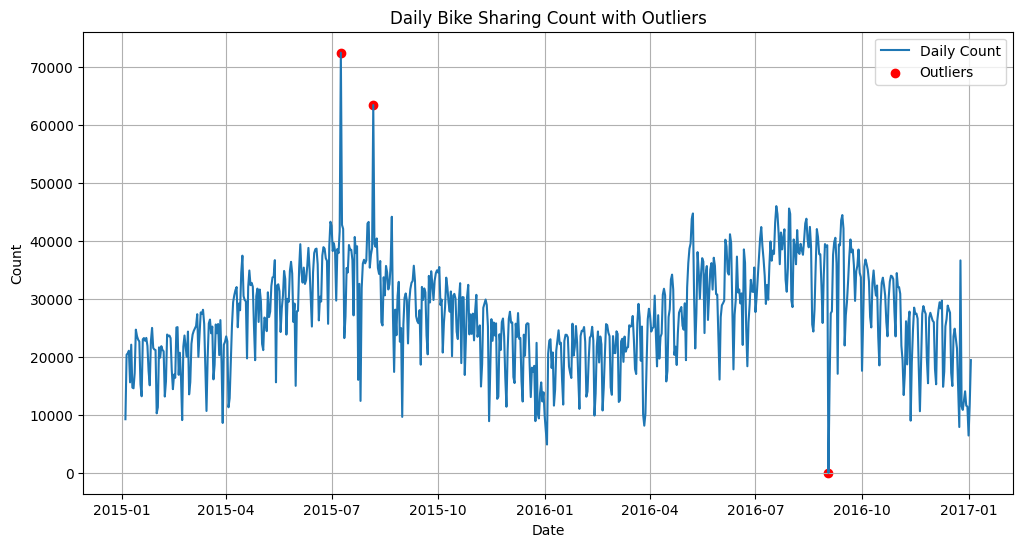

Outliers:
              cnt
timestamp        
2015-07-09  72504
2015-08-06  63468
2016-09-02      0


In [78]:
# Hitung Q1, Q3, dan IQR
Q1 = daily_df['cnt'].quantile(0.25)
Q3 = daily_df['cnt'].quantile(0.75)
IQR = Q3 - Q1

# Tentukan batas bawah dan batas atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Tandai outlier
outliers = daily_df[(daily_df['cnt'] < lower_bound) | (daily_df['cnt'] > upper_bound)]

# Plot data harian dan outlier
plt.figure(figsize=(12, 6))
plt.plot(daily_df.index, daily_df['cnt'], label='Daily Count')  # semua data
plt.scatter(outliers.index, outliers['cnt'], color='red', label='Outliers')  # tandai outlier merah
plt.title('Daily Bike Sharing Count with Outliers')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.show()

# Tampilkan outlier
print("Outliers:")
print(outliers)


Interpretasi :<br>
Terdapat 3 tanggal yang mengandung outlier, saya menganggap bahwa data ini tidak wajar, bukan nilai yang sebenarnya sehingga saya memutuskan untuk menangani outlier ini dengan imputasi data dengan interpolasi berdasarkan waktu (tanggal), saya tidak menghapusnya karna kelengkapan data penting untuk prediksi time series.

In [79]:
# Ganti outlier dengan NaN
daily_df['cnt'] = daily_df['cnt'].where(~daily_df.index.isin(outliers.index), np.nan)

# Ganti outlier dengan nilai yang di-interpolasi dari data sekitar sebelum/sesudah (berdasarkan tanggal terdekat)
daily_df['cnt'] = daily_df['cnt'].interpolate(method='time')

In [80]:
# Tampilkan data outlier yang sudah ditangani
selected_date = ['2015-07-09', '2015-08-06', '2016-09-02']
data_selected = daily_df.loc[selected_date]

# Tampilkan data
print(data_selected)

                cnt
timestamp          
2015-07-09  42241.0
2015-08-06  39128.0
2016-09-02  27267.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
LSTM RMSE: 6457.43, MAE: 4781.28


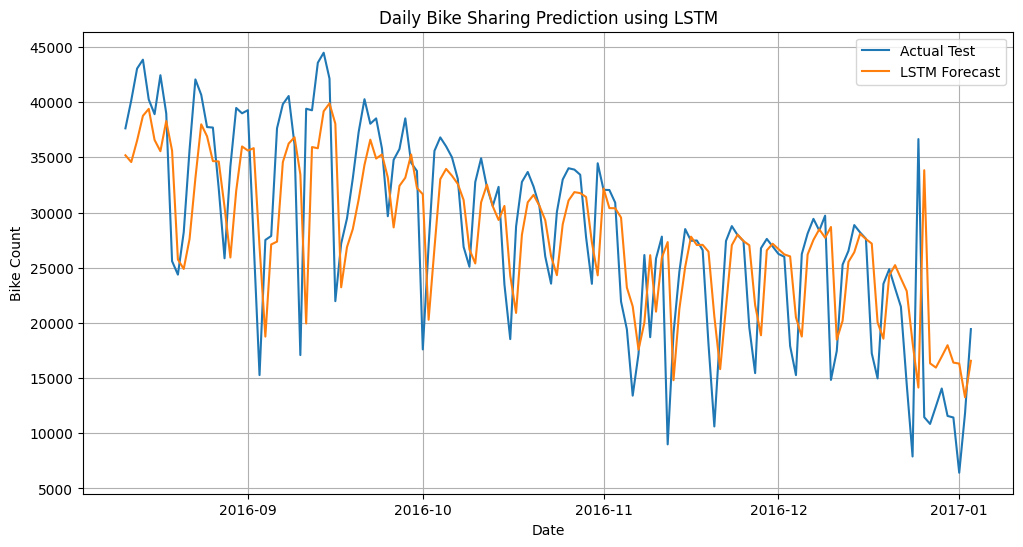

In [81]:
# Normalisasi data ke rentang [0, 1] menggunakan MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_df[['cnt']])

# Definisikan fungsi untuk membuat dataset berbentuk sequence berdasarkan look_back
def create_dataset(data, look_back):
    X, y = [], []       # Inisialisasi list kosong untuk input (X) dan output (y)
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])   # Ambil sequence sepanjang look_back sebagai fitur
        y.append(data[i + look_back])   # Ambil nilai setelah look_back sebagai target
    return np.array(X), np.array(y)   # Kembalikan X dan y sebagai array numpy

look_back = 1  # menggunakan 1 hari sebelumnya untuk memprediksi hari ke 2
X, y = create_dataset(scaled_data, look_back)

# Reshape X agar sesuai format input LSTM: [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]  # Data input untuk training dan testing
y_train, y_test = y[:train_size], y[train_size:]  # Data target untuk training dan testing

# Membangun arsitektur model LSTM
model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(look_back, 1)),    # Layer LSTM dengan 50 unit dan fungsi aktivasi tanh
    Dense(1)    # Layer Dense (output layer) dengan 1 neuron untuk prediksi
])

# Compile model dengan optimizer Adam dan loss function MSE
model_lstm.compile(optimizer='adam', loss='mse')

# Melatih model menggunakan data training, selama 50 epoch dengan batch_size 32
# Validasi dilakukan dengan data test
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32,
                         validation_data=(X_test, y_test), verbose=0)

# Melakukan prediksi menggunakan model yang sudah dilatih pada data test (Forecast)
lstm_forecast = model_lstm.predict(X_test)

# Inverse transform / Membalikkan skala data hasil prediksi ke nilai aslinya
lstm_forecast_inv = scaler.inverse_transform(lstm_forecast)
y_test_inv = scaler.inverse_transform(y_test)   # Membalikkan skala data target asli

# Evaluasi performa model menggunakan MSE, RMSE, dan MAE
mse = mean_squared_error(y_test_inv, lstm_forecast_inv)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_inv, lstm_forecast_inv)
print(f'LSTM RMSE: {rmse:.2f}, MAE: {mae:.2f}')   # Menampilkan hasil evaluasi

# Membuat figure untuk visualisasi hasil prediksi
plt.figure(figsize=(12, 6))

# Membuat index waktu yang sesuai untuk data hasil prediksi
plot_index = daily_df.index[look_back:]

# Plot nilai aktual dari data test
plt.plot(plot_index[train_size:], y_test_inv, label='Actual Test')
plt.plot(plot_index[train_size:], lstm_forecast_inv, label='LSTM Forecast')   # Plot nilai prediksi hasil model LSTM
plt.title('Daily Bike Sharing Prediction using LSTM')   # Menambahkan judul grafik
plt.xlabel('Date')  # Menambahkan label sumbu X
plt.ylabel('Bike Count')  # Menambahkan label sumbu Y
plt.legend()    # Menambahkan legenda
plt.grid(True)    # Menampilkan grid pada grafik
plt.show()    # Menampilkan grafik ke layar

Interpretasi: <br>
- RMSE (Root Mean Squared Error) = 6457.43, Ini artinya rata-rata jarak prediksi terhadap nilai aslinya sekitar 6457 sepeda.

- MAE (Mean Absolute Error) = 4781.28, Ini artinya, rata-rata kesalahan prediksi adalah sekitar 4781 sepeda.

- Model cukup bagus, sudah mengikuti tren (naik-turun) secara umum. Tapi, prediksi masih cukup kasar rata-rata salah sekitar 4700–6400an sepeda.